In [1]:
import torch
import config

from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
from torch.utils.data import Dataset
import numpy as np
import mrcfile
import cv2
import wandb
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
image_path = sorted(list(glob.glob('/media/ashwin/data2/ViTPicker_data/10406_10/micrographs/*.mrc')))

In [3]:
transforms = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)),
                            transforms.ToTensor()
                        ])

In [4]:
def additional_transform(image):
    i_min = image.min()
    i_max = image.max()

    image = ((image - i_min)/(i_max - i_min))
    return image

In [5]:
class Cryo_Dataset(Dataset):
    def __init__(self, img_dir, transforms):
        super().__init__()
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        image = mrcfile.read(self.img_dir[idx])
        image = image.T
        image = np.rot90(image)
        if self.transforms is not None:
            image = self.transforms(image)
        image = additional_transform(image)
          
        return image

In [6]:
dataset = Cryo_Dataset(img_dir=image_path, transforms=transforms)

In [7]:
# Creating data indices for training and validation splits:
batch_size = 1
validation_split = .1
shuffle_dataset = False  #later change it into True
random_seed= 42
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

print(len(train_indices), len(val_indices))

9 1


In [8]:
train_loader = DataLoader(dataset = dataset, batch_size =1, sampler=train_sampler)
validation_loader = DataLoader(dataset = dataset, batch_size =1, sampler=valid_sampler)

In [9]:
image_batch = next(iter(validation_loader))
image = image_batch[0]
image.shape
image.type()

'torch.FloatTensor'

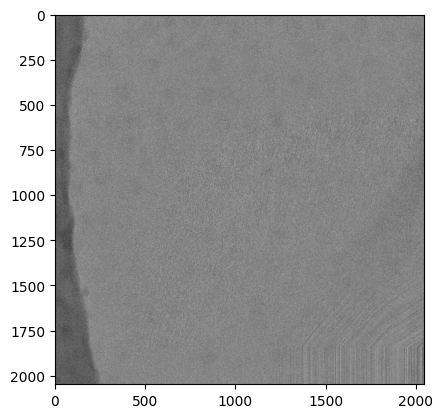

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0), cmap='gray') # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]


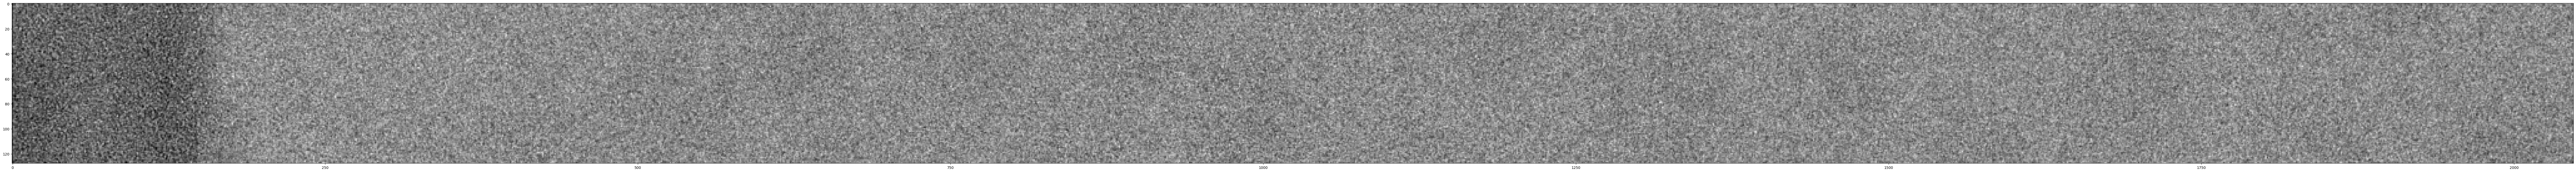

In [17]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 128
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :], cmap='gray');

Number of patches per row: 16.0
Patch size: 128 pixels x 128 pixels


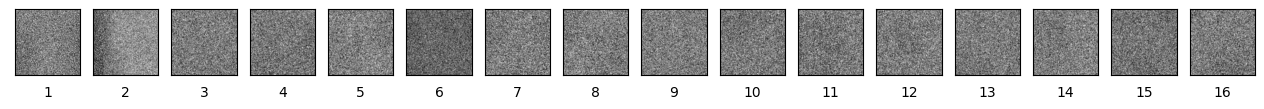

In [18]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 2048
patch_size = 128
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :], cmap='gray'); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 16.0        
Number of patches per column: 16.0        
Total patches: 256.0        
Patch size: 128 pixels x 128 pixels


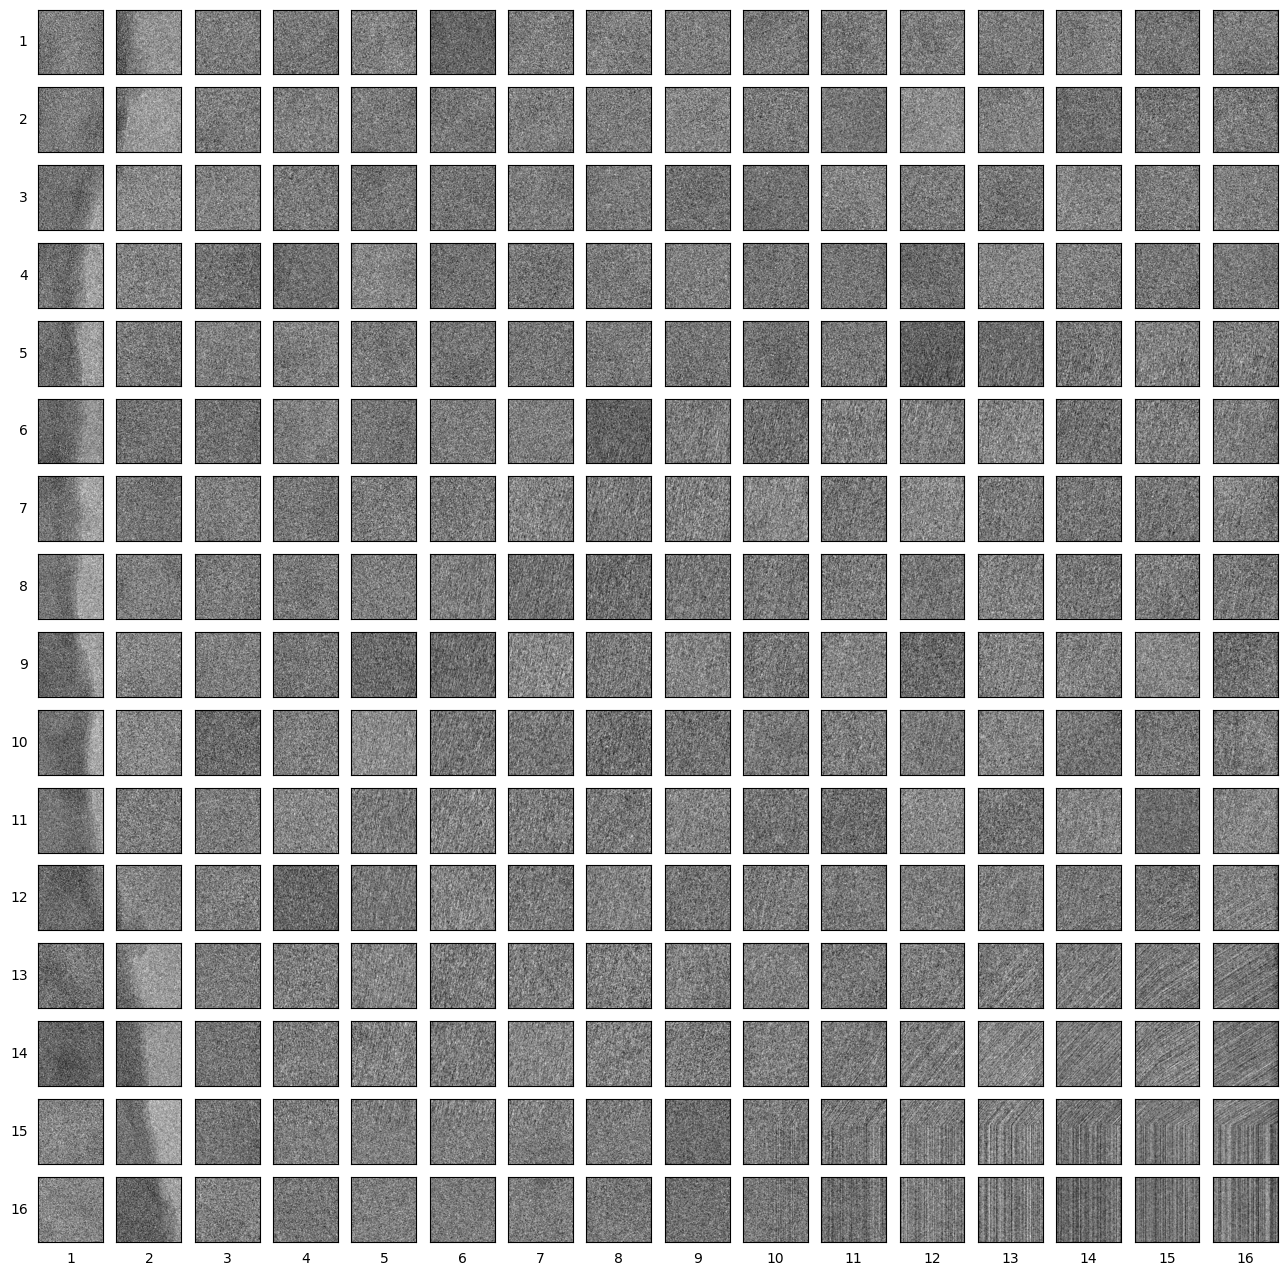

In [19]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 2048
patch_size = 128
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :], cmap='gray') # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
plt.show()

0
tensor([[[0.1036, 0.3206, 0.2548,  ..., 0.5780, 0.4224, 0.4706],
         [0.1604, 0.3573, 0.3301,  ..., 0.5956, 0.4094, 0.3778],
         [0.2663, 0.5046, 0.4898,  ..., 0.5274, 0.5572, 0.4924],
         ...,
         [0.1543, 0.3152, 0.3918,  ..., 0.6913, 0.3515, 0.3513],
         [0.2024, 0.3799, 0.3100,  ..., 0.6076, 0.3789, 0.4366],
         [0.2385, 0.4233, 0.2816,  ..., 0.6193, 0.3620, 0.4547]]])
torch.FloatTensor
torch.Size([1, 2048, 2048])


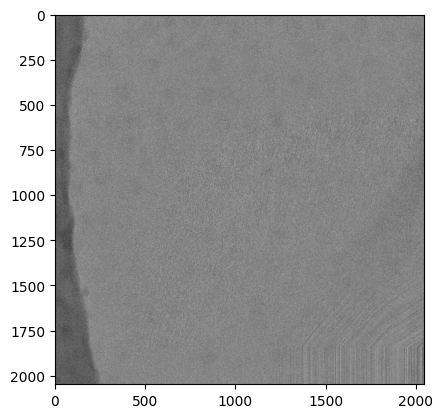

In [14]:
for i, data in enumerate(validation_loader):
    print(i)
    sample_image = data
    print(sample_image[0])
    print(sample_image[0].type())
    print(sample_image[0].shape)
    # Plot image with matplotlib
    plt.imshow(sample_image[0].permute(1, 2, 0), cmap='gray') # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
